In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import pyro
import pyro.distributions as dist
from pyro import infer
from pyro import optim
from pyro.distributions import constraints
from pyro.nn import PyroModule, PyroSample

from torchvision import datasets, transforms

In [2]:
# Create loaders for train and test data sets
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=False, transform=transforms.Compose([transforms.ToTensor(),])
                       ),
        batch_size=None)

In [3]:
class ConvolutionalNN(nn.Module):
    """A simple convolutional NN using base PyTorch"""
    
    def __init__(self, xdim=28, ydim=28, n_classes=10,
                 hidden_channels=4, hidden_size=20):
        super().__init__()
        self.xdim = xdim
        self.ydim = ydim
        self.hidden_channels = hidden_channels
        try:
            assert self.xdim % 2 == 0 and self.ydim % 2 == 0
        except AssertionError:
            raise AssertionError('xdim and ydim must both be even')
        self.n_classes = n_classes
        # start with convolutional layers
        # (1 x xdim x ydim) -> (hidden_channels x xdim x ydim)
        self.conv1 = nn.Conv2d(1, self.hidden_channels, kernel_size=3, padding=1)
        # (hidden_channels x xdim x ydim) -> (hidden_channels, xdim/2, ydim/2)
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # next have linear layers
        # (hidden_channels x xdim/2 x ydim/2) -> (hidden_size)
        self.lin1 = nn.Linear(self.hidden_channels * xdim * ydim // 4, hidden_size)
        # Output layer: (hidden_channels) -> (n_classes)
        self.lin2 = nn.Linear(hidden_size, n_classes)
        
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        # flatten before linear layers
        x = x.view(-1, self.hidden_channels * self.xdim * self.ydim // 4)
        x = nn.functional.relu(self.lin1(x))
        # Uses log softmax activation; later to be plugged in as logits for Categorical dist
        x = nn.functional.log_softmax(self.lin2(x), dim=-1)
        return x
        
        

In [4]:
class BayesianCNN(ConvolutionalNN, PyroModule):
    """Convolutional NN with weights treated as random variables"""
    
    def __init__(self, xdim=28, ydim=28, n_classes=10):
        super(BayesianCNN, self).__init__(xdim, ydim, n_classes)
        # Set standard normal priors on all weights & biases
        for param in self.parameters():
            param = PyroSample(lambda self: dist.Normal(0, 1).expand(param.shape).to_event(param.dim()))

            
class BayesianCNNModel(PyroModule):
    """Model for fitting BayesianCNN with AVI"""
    
    def __init__(self, xdim=28, ydim=28, n_classes=10):
        super().__init__()
        self.bayesianCNN = BayesianCNN(xdim, ydim, n_classes)
        print(f'number of parameters is {sum(p.numel() for p in self.bayesianCNN.parameters())}')
        self.guide = infer.autoguide.AutoNormal(self)
    
    def forward(self, X, y=None):
        cnn_out = self.bayesianCNN(X)
        with pyro.plate('instances', len(X)):
            return pyro.sample('obs', dist.Categorical(logits=cnn_out), obs=y)
    
    def fit(self, loader, autoguide=infer.autoguide.AutoNormal,
            optimizer=optim.Adam, optimizer_params={'lr': 0.01}, n_epochs=5):
        svi = infer.SVI(self, self.guide, optimizer(optimizer_params), infer.Trace_ELBO())
        total_size = len(loader.dataset)
        for i in range(n_epochs):
            loss = 0
            correct = 0
            for X, y in loader:
                loss += svi.step(X, y)
                with torch.no_grad():
                    correct += (self.forward(X) == y).sum().item()
            print(f'Epoch {i}: loss = {loss:.5f}, accuracy = {correct / total_size:.5f}')
    
    def predict(self, X, n_samples=100, return_sites=('obs',)):
        predictive = infer.Predictive(self, guide=self.guide, num_samples=n_samples,
                                               return_sites=return_sites)
        return predictive(X)

In [5]:
pyro.clear_param_store()
bnn = BayesianCNNModel()
bnn.fit(train_loader, optimizer_params={'lr': 0.02}, n_epochs=6)

number of parameters is 15950
Epoch 0: loss = 13074.67668, accuracy = 0.91120
Epoch 1: loss = 7100.54748, accuracy = 0.95553
Epoch 2: loss = 6016.52075, accuracy = 0.96440
Epoch 3: loss = 5540.60053, accuracy = 0.96848
Epoch 4: loss = 5314.61256, accuracy = 0.97135
Epoch 5: loss = 5057.24207, accuracy = 0.97147


In [6]:
# Sample posterior distribution for testing data
predictive = infer.Predictive(bnn, guide=bnn.guide, num_samples=1,
                              return_sites=('obs',))
def get_pred(x):
    pred = predictive(X.unsqueeze(0))['obs'].flatten().mode().values.item()
    return pred

correct = 0
total = 0

for X, y in test_loader:
    pred = get_pred(X)
    if pred == y:
        correct += 1
    total += 1

print(f'accuracy is {correct / total:.5f}')

accuracy is 0.96300


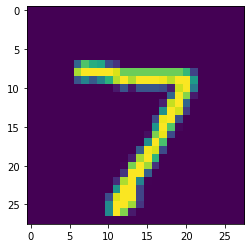

predicted: 7, actual: 7


In [7]:
# Show what output looks like with example value
X, y = next(iter(test_loader))

plt.imshow(X.squeeze())
plt.show()

pred = get_pred(X)
print(f'predicted: {pred}, actual: {y}')

Here I have not made use of the posterior sampling distributions for the parameters of the model -- I just wanted to demonstrate it was possible to make a Bayesian convolutional network. However, the model (and posterior prediction function) could easily be slightly modified to show distributions for parameters.